## Methodology

- Train an autoencoder on all of the data available to be able to reconstruct any image with an identity
- accrue an average representation of all of the vangogh images in the latent space of this autoencoder
- accrue an average representation of all NON vangogh images in the latent space of the autoencoder

- v1
    - find the common values between all vangogh images and then take a weighted sum between that and the latent space of an arbitrary image
- v2
    - find the difference between the average vangogh image and the average image and then take a weighted sum between that and the latent space of an arbitrary image

## Version 1

In [1]:
import os
import PIL
import time
import imageio
import numpy as np
import tensorflow as tf
import tensorflow.data as tfd
import matplotlib.pyplot as pt

from glob import glob
from tqdm import tqdm
from typing import Iterable, List, Tuple, Any

In [2]:
def list_files(directory: str, search: Iterable) -> List[str]:
    """
    list files
    """
    if isinstance(search, str):
        search = [search]

    output: List[str] = []
    for term in search:
        for filepath in glob(os.path.join(directory, term)):
            output.append(filepath)

    return output

In [3]:
def load_random_image(directory: str, search: Iterable) -> np.ndarray:
    filepaths = list_files(directory, search)
    rand_index = np.random.randint(0, high=len(filepaths))
    return np.asarray(PIL.Image.open(filepaths[rand_index]))

## Dataset
- Train: 8868 images
- Test: 1697

In [4]:
data_dir = 'data'
random_image_dir = os.path.join(data_dir, 'random_images')
vangogh_image_dir = os.path.join(data_dir, 'vangogh_images')

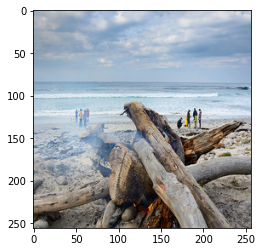

In [5]:
pt.imshow(load_random_image(random_image_dir, "*.jpg"))

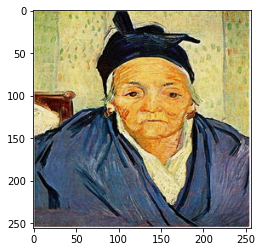

In [6]:
pt.imshow(load_random_image(vangogh_image_dir, "*.jpg"))

## Time to define the data generators

In [7]:
BATCH_SIZE = 16
BUFFER_SIZE = 64
DATASET_SIZE = len(list_files(random_image_dir, "*.jpg")) + len(list_files(vangogh_image_dir, "*.jpg"))

In [8]:
dgen_params = dict(
    rescale           =  1./255,
    shear_range       =  0.0,
    zoom_range        =  0.0,
    horizontal_flip   =  True,
    brightness_range  =  (0.95, 1.2),
    validation_split = 0.2,
)

gen_params = dict(
    target_size       =  (256, 256),
    batch_size        =  BATCH_SIZE,
    color_mode        =  'rgb',
    class_mode        =  'binary',
)

In [9]:
dgen = tf.keras.preprocessing.image.ImageDataGenerator(
    **dgen_params
)

train_gen = dgen.flow_from_directory(
    data_dir, 
    subset="training",
    **gen_params,
)

val_gen = dgen.flow_from_directory(
    data_dir, 
    subset="validation",
    **gen_params,
)

Found 8452 images belonging to 3 classes.
Found 2112 images belonging to 3 classes.


In [10]:
train_ds = tfd.Dataset.from_generator(lambda: train_gen, (tf.float32, tf.int32))
val_ds = tfd.Dataset.from_generator(lambda: val_gen, (tf.float32, tf.int32))

[1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1]


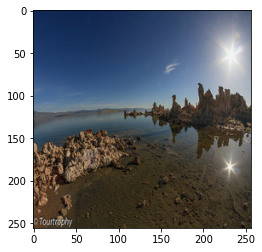

In [11]:
for img, label in train_ds.take(1).as_numpy_iterator():
    print(label)
    pt.imshow(img[0, ...])

[1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1]


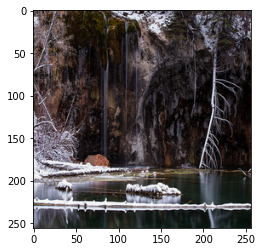

In [12]:
for img, label in val_ds.take(1).as_numpy_iterator():
    print(label)
    pt.imshow(img[0, ...])

## At this point, we know that our train and val generators contain our images which are labeled 1 for a random image and 2 for a vangogh image

In [13]:
from tensorflow.keras import layers
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPool2D, Dense, Reshape, LeakyReLU, Dropout, Flatten, Add

def downsampler_unit(input_tensor, num_features, filter_shape, strides_shape, padding, bias, max_pooling: bool = False):
    layer1 = Conv2D(num_features, filter_shape, strides=strides_shape, padding=padding, use_bias=bias)(input_tensor)
    layer2 = Conv2D(num_features, filter_shape, strides=strides_shape, padding=padding, use_bias=bias)(layer1)
    layer3 = InstanceNormalization()(layer2)
    if max_pooling: 
        layer2 = MaxPool2D((2, 2))(layer2)
    layer2 = LeakyReLU()(layer2)

    return tf.keras.models.Model(inputs=input_tensor, outputs=layer3)

def upsampler_unit(input_tensor, scaling, filter_shape, strides_shape, padding, bias, instance_norm: bool = False):
    layer1 = Conv2DTranspose(scaling, filter_shape, strides=strides_shape, padding=padding, use_bias=bias)(input_tensor)
    layer2 = Conv2DTranspose(scaling, filter_shape, strides=strides_shape, padding=padding, use_bias=bias)(layer1)
    if instance_norm:
        layer2 = InstanceNormalization()(layer2)
    layer2 = LeakyReLU()(layer2)
    
    return tf.keras.models.Model(inputs=input_tensor, outputs=layer2)

def latent_space_unit(input_tensor, latent_dim, dropout_pct):
    dropout = Dropout(dropout_pct)(input_tensor)
    flatten = Flatten()(dropout)
    latent_space = Dense(latent_dim)(flatten)

    return tf.keras.models.Model(inputs=input_tensor, outputs=latent_space)

class Autoencoder(tf.keras.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.multiplier = 12
        self.latent_dim = 256*self.multiplier

        self.encoder_input = Input(shape=(256, 256, 3))
        print(tuple(self.encoder_input.get_shape()))
        self.ds1 = downsampler_unit(self.encoder_input, 128, (10, 10), (2, 2), 'same', False, False)
        print(self.ds1.output_shape)
        self.ds2 = downsampler_unit(Input(shape=self.ds1.output_shape[1:]), 512, (10, 10), (2, 2), 'same', True, False)
        print(self.ds2.output_shape)
        self.ds3 = downsampler_unit(Input(shape=self.ds2.output_shape[1:]), 1024, (5, 5), (2, 2), 'same', True, False)
        print(self.ds3.output_shape)
        
        self.latent_space = latent_space_unit(Input(shape=(self.ds3.output_shape[1:])), self.latent_dim, 0.3)
        
        self.decoder_input = Input(shape=(16, 16, self.multiplier))
        self.up1 = upsampler_unit(self.decoder_input, 512, (1, 1), (1, 1), 'same', True, False)
        print(self.up1.output_shape)
        self.up2 = upsampler_unit(Input(shape=self.up1.output_shape[1:]), 128, (1, 1), (2, 2), 'same', True, False)
        print(self.up2.output_shape)
        self.up3 = upsampler_unit(Input(shape=self.up2.output_shape[1:]), 3, (1, 1), (2, 2), 'same', True, False)
        print(self.up3.output_shape)
        
    def plot_model_graph(self):
        tf.keras.utils.plot_model(
            tf.keras.models.Model(
                inputs=self.encoder_input, 
                outputs=self.call(self.encoder_input)), 
            'functional_components.png', 
            expand_nested=True, 
            show_shapes=True)
    
    def get_encoded_image(self, image):
        layer1 = self.ds1(image_batch)
        layer2 = self.ds2(layer1)
        layer3 = self.ds3(layer2)
        latent_space = self.latent_space(layer3)
        
        return latent_space

    def call(self, image_batch):
        layer1 = self.ds1(image_batch)
        layer2 = self.ds2(layer1)
        layer3 = self.ds3(layer2)
        
        latent_space = self.latent_space(layer3)
                                              
        reshape = Reshape((16, 16, self.multiplier))(latent_space)
        layer4 = self.up1(reshape)
        skip_connnection1 = Add()([layer2, layer4])
        layer5 = self.up2(skip_connnection1)
        skip_connection2 = Add()([layer1, layer5])
        layer6 = self.up3(skip_connection2)
        
        return layer6

/home/mycicle/anaconda3/envs/cs583/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:37: UserWarning: You are currently using a nightly version of TensorFlow (2.5.0-dev20210130). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


In [14]:
autoencoder = Autoencoder()

(None, 256, 256, 3)
(None, 64, 64, 128)
(None, 16, 16, 512)
(None, 4, 4, 1024)
(None, 16, 16, 512)
(None, 64, 64, 128)
(None, 256, 256, 3)


In [15]:
autoencoder.build(input_shape=(BATCH_SIZE, 256, 256, 3))
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 64, 64, 128)       1677056   
_________________________________________________________________
model_1 (Functional)         (None, 16, 16, 512)       32770048  
_________________________________________________________________
model_2 (Functional)         (None, 4, 4, 1024)        39325696  
_________________________________________________________________
model_3 (Functional)         (None, 3072)              50334720  
_________________________________________________________________
model_4 (Functional)         (None, 16, 16, 512)       269312    
_________________________________________________________________
model_5 (Functional)         (None, 64, 64, 128)       82176     
_________________________________________________________________
model_6 (Functional)         (None, 256, 256, 3)       

In [16]:
autoencoder.plot_model_graph()

In [17]:
mse = tf.keras.losses.MSE

In [18]:
def autoencoder_loss(original_image, decoded_image):
    return mse(original_image, decoded_image)

In [19]:
autoencoder_optimizer = tf.keras.optimizers.RMSprop(lr=2e-4)

In [20]:
checkpoint_dir: str = 'autoencoder_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(autoencoder_optimizer=autoencoder_optimizer,
                                    autoencoder=autoencoder,
                                )

In [21]:
EPOCHS = 30
EPOCH_BATCHES = 2250

In [22]:
@tf.function
def train_step(images):
    loss = None
    with tf.GradientTape() as grad:
        autoencoded_images = autoencoder(images, training=True)
        loss = autoencoder_loss(images, autoencoded_images)
    gradients_of_autoencoder = grad.gradient(loss, autoencoder.trainable_variables)
    autoencoder_optimizer.apply_gradients(zip(gradients_of_autoencoder, autoencoder.trainable_variables))
    
    return loss

In [23]:
def train(images, epochs, epoch_batches, img):
    with tqdm(total=epochs*epoch_batches) as pbar:
        for epoch in range(epochs):
            start = time.time()
            for image, _ in images.take(epoch_batches):
                loss = tf.math.reduce_mean(tf.math.reduce_sum(train_step(image)))
                pbar.update(1)
            if (epoch+1) % 1 == 0:
#                 checkpoint.save(file_prefix=checkpoint_prefix)
                print(f'loss for epoch {epoch} : {loss}')
                autoencoder.save('model_200', save_format='tf')
                pt.imshow(autoencoder(img[0, ...].reshape(1, *img[0,...].shape))[0, ...])
                pt.savefig(f'epoch_output/{epoch}.png')
        print(f"Time for epoch {epoch} is {time.time()-start}")

In [24]:
im = None
for img, _ in train_ds.take(1).as_numpy_iterator():
    im = img[0, ...].reshape(1, *img[0,...].shape)

  3%|▎         | 2250/67500 [16:15<7:42:54,  2.35it/s]

loss for epoch 0 : 74351.796875
INFO:tensorflow:Assets written to: model_200/assets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  7%|▋         | 4500/67500 [32:18<7:27:04,  2.35it/s] 

loss for epoch 1 : 78129.171875
INFO:tensorflow:Assets written to: model_200/assets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 10%|█         | 6750/67500 [48:20<7:10:33,  2.35it/s] 

loss for epoch 2 : 71354.0234375
INFO:tensorflow:Assets written to: model_200/assets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 13%|█▎        | 9000/67500 [1:04:23<6:52:56,  2.36it/s]

loss for epoch 3 : 80482.390625
INFO:tensorflow:Assets written to: model_200/assets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 17%|█▋        | 11250/67500 [1:20:25<6:38:16,  2.35it/s]

loss for epoch 4 : 63707.3359375
INFO:tensorflow:Assets written to: model_200/assets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 20%|██        | 13500/67500 [1:36:28<6:22:53,  2.35it/s] 

loss for epoch 5 : 86755.46875
INFO:tensorflow:Assets written to: model_200/assets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 23%|██▎       | 15750/67500 [1:52:30<6:07:44,  2.35it/s] 

loss for epoch 6 : 98554.59375
INFO:tensorflow:Assets written to: model_200/assets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 27%|██▋       | 18000/67500 [2:08:31<5:50:15,  2.36it/s] 

loss for epoch 7 : 80061.296875
INFO:tensorflow:Assets written to: model_200/assets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 30%|███       | 20250/67500 [2:24:32<5:35:23,  2.35it/s] 

loss for epoch 8 : 83762.9140625
INFO:tensorflow:Assets written to: model_200/assets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 33%|███▎      | 22500/67500 [2:40:34<5:19:11,  2.35it/s] 

loss for epoch 9 : 84003.703125
INFO:tensorflow:Assets written to: model_200/assets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 37%|███▋      | 24750/67500 [2:56:35<5:03:24,  2.35it/s] 

loss for epoch 10 : 86711.71875
INFO:tensorflow:Assets written to: model_200/assets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 40%|████      | 27000/67500 [3:12:36<4:47:20,  2.35it/s] 

loss for epoch 11 : 89129.46875
INFO:tensorflow:Assets written to: model_200/assets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 43%|████▎     | 29250/67500 [3:28:37<4:31:27,  2.35it/s] 

loss for epoch 12 : 84268.28125
INFO:tensorflow:Assets written to: model_200/assets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 47%|████▋     | 31500/67500 [3:44:38<4:15:15,  2.35it/s] 

loss for epoch 13 : 82380.484375
INFO:tensorflow:Assets written to: model_200/assets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 50%|█████     | 33750/67500 [4:00:39<3:58:55,  2.35it/s] 

loss for epoch 14 : 81856.328125
INFO:tensorflow:Assets written to: model_200/assets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 53%|█████▎    | 36000/67500 [4:16:41<3:43:41,  2.35it/s] 

loss for epoch 15 : 82290.0859375
INFO:tensorflow:Assets written to: model_200/assets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 57%|█████▋    | 38250/67500 [4:32:42<3:27:45,  2.35it/s] 

loss for epoch 16 : 79873.4375
INFO:tensorflow:Assets written to: model_200/assets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 60%|██████    | 40500/67500 [4:48:43<3:11:58,  2.34it/s] 

loss for epoch 17 : 96118.375
INFO:tensorflow:Assets written to: model_200/assets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 63%|██████▎   | 42750/67500 [5:04:45<2:55:33,  2.35it/s] 

loss for epoch 18 : 69544.78125
INFO:tensorflow:Assets written to: model_200/assets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 67%|██████▋   | 45000/67500 [5:20:46<2:39:29,  2.35it/s] 

loss for epoch 19 : 93660.421875
INFO:tensorflow:Assets written to: model_200/assets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 70%|███████   | 47250/67500 [5:36:47<2:23:53,  2.35it/s] 

loss for epoch 20 : 88018.078125
INFO:tensorflow:Assets written to: model_200/assets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 73%|███████▎  | 49500/67500 [5:52:48<2:07:38,  2.35it/s] 

loss for epoch 21 : 80275.3125
INFO:tensorflow:Assets written to: model_200/assets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 77%|███████▋  | 51750/67500 [6:08:50<1:51:39,  2.35it/s]

loss for epoch 22 : 96868.734375
INFO:tensorflow:Assets written to: model_200/assets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 80%|████████  | 54000/67500 [6:24:51<1:35:44,  2.35it/s]

loss for epoch 23 : 94180.1328125
INFO:tensorflow:Assets written to: model_200/assets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 83%|████████▎ | 56250/67500 [6:40:52<1:19:40,  2.35it/s]

loss for epoch 24 : 89509.5
INFO:tensorflow:Assets written to: model_200/assets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 87%|████████▋ | 58500/67500 [6:56:53<1:03:52,  2.35it/s]

loss for epoch 25 : 61709.26171875
INFO:tensorflow:Assets written to: model_200/assets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 90%|█████████ | 60750/67500 [7:12:55<47:52,  2.35it/s]  

loss for epoch 26 : 81421.1640625
INFO:tensorflow:Assets written to: model_200/assets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 93%|█████████▎| 63000/67500 [7:28:57<31:54,  2.35it/s]  

loss for epoch 27 : 70223.0
INFO:tensorflow:Assets written to: model_200/assets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 97%|█████████▋| 65250/67500 [7:44:58<15:56,  2.35it/s]  

loss for epoch 28 : 97316.359375
INFO:tensorflow:Assets written to: model_200/assets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 67500/67500 [8:01:00<00:00,  2.35it/s]  

loss for epoch 29 : 96657.328125
INFO:tensorflow:Assets written to: model_200/assets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 67500/67500 [8:01:05<00:00,  2.34it/s]

Time for epoch 29 is 961.3800256252289


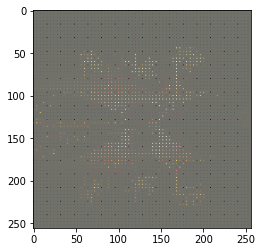

In [25]:
train(train_ds, EPOCHS, EPOCH_BATCHES, im)

In [26]:
# for img, _ in train_ds.take(1).as_numpy_iterator():
#     pt.imshow(autoencoder(img[0, ...].reshape(1, *img[0,...].shape))[0, ...])

In [27]:
autoencoder.save('model_200', save_format='tf')

INFO:tensorflow:Assets written to: model_200/assets


In [28]:
newauto = tf.keras.models.load_model('model_200')

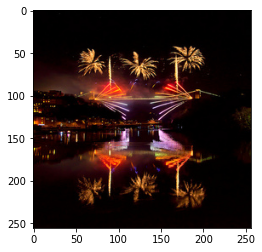

In [29]:
pt.imshow(im[0, ...])

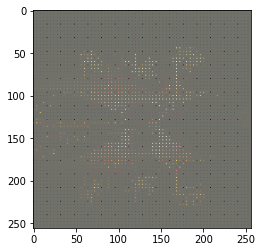

In [30]:
pt.imshow(autoencoder(im[0, ...].reshape(1, *im[0,...].shape))[0, ...])

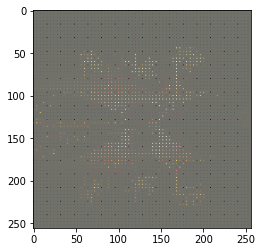

In [31]:
pt.imshow(newauto(im[0, ...].reshape(1, *im[0,...].shape))[0, ...])